# Importing the libraries

In [1]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow import keras
import platform
from tensorflow.keras import layers, optimizers, losses, models, Input, Model
import time # Per misurare il tempo di training
from tensorflow.keras.callbacks import EarlyStopping # Per l'early stopping
import matplotlib.pyplot as plt
from tqdm import tqdm # Per mostrare una barra di progresso
from tensorflow.keras.models import load_model

# Set seeds for random operations.

In [2]:
# --- 1. Impostazione del Seed Globale all'inizio del tuo script ---
# Questo è il punto chiave per la riproducibilità di TUTTO ciò che segue.
MASTER_RANDOM_SEED = 42
np.random.seed(MASTER_RANDOM_SEED)
random.seed(MASTER_RANDOM_SEED) # Imposta anche il seed per la libreria 'random' di Python se la usi
tf.random.set_seed(MASTER_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(MASTER_RANDOM_SEED) # Per operazioni basate su hash (es. ordine dei dizionari)
os.environ['TF_DETERMINISTIC_OPS'] = '1' # Forza operazioni deterministiche in TensorFlow 2.x

# Print the HW Specs.

In [3]:
print("--- Dettagli dell'Architettura Hardware della Sessione Colab ---\n")

# --- 1. Dettagli CPU ---
print("--- Dettagli CPU ---")
!lscpu
print("\n")

# --- 2. Dettagli RAM (Memoria) ---
print("--- Dettagli RAM (Memoria) ---")
!cat /proc/meminfo | grep MemTotal
print("\n")

# --- 3. Dettagli Spazio su Disco ---
print("--- Dettagli Spazio su Disco ---")
!df -h /
print("\n")

# --- 4. Dettagli Acceleratore Hardware (GPU/TPU) ---
print("--- Dettagli Acceleratore Hardware (GPU/TPU) ---")
try:
    tpu_address = os.environ.get('COLAB_TPU_ADDR')
    if tpu_address:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print(f"Tipo Acceleratore: TPU (indirizzo: {tpu_address})")
        print("Dispositivi TPU disponibili:")
        for device in tf.config.list_logical_devices('TPU'):
            print(f"  - {device.name}")
    else:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"Tipo Acceleratore: GPU")
            for gpu in gpus:
                print(f"  - Dispositivo GPU rilevato: {gpu.name}")
            print("\nDettagli GPU specifici (da `!nvidia-smi`):")
            !nvidia-smi
        else:
            print("Tipo Acceleratore: Nessuna GPU o TPU rilevata (in uso CPU)")

except Exception as e:
    print(f"Si è verificato un errore durante la rilevazione dell'acceleratore: {e}")
    print("Tentativo di rilevare i dispositivi TensorFlow standard:")
    devices = tf.config.list_logical_devices()
    if devices:
        for device in devices:
            print(f"  - Dispositivo rilevato: {device.name}, Tipo: {device.device_type}")
    else:
        print("Nessun dispositivo TensorFlow rilevato.")

print("\n--- Analisi Dettagli Hardware Completata ---")

--- Dettagli dell'Architettura Hardware della Sessione Colab ---

--- Dettagli CPU ---
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4

# Connect To Gdrive to store the datasets created.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Function for calculating BER

In [8]:
# Funzione per calcolare il BER
def calculate_ber(model, snr_test_data_path, max_samples=500000):
    ber_values = []
    snr_points = list(range(0, 21))

    for snr_db in tqdm(snr_points, desc="Calculating BER"):
        test_file = os.path.join(snr_test_data_path, f"test_{snr_db}_SNR.npz")
        if not os.path.exists(test_file):
            print(f"File non trovato: {test_file}. Salto questo SNR.")
            ber_values.append(np.nan)
            continue

        data = np.load(test_file)
        X_batch, y_true_batch = data['X_test'], data['y_test']
        symbols_in_batch = X_batch.shape[0]

        if symbols_in_batch == 0:
            ber_values.append(np.nan)
            continue

         # --- Estrazione casuale di un sottoinsieme ---
        if len(X_batch) > max_samples:
            print("entrato nell'if di riduzione campioni per ridurre tempi.")
            idx = np.random.choice(len(X_batch), max_samples, replace=False)
            X_batch = X_batch[idx]
            y_true_batch = y_true_batch[idx]

        predictions = model.predict(X_batch, batch_size=10000, verbose=0)
        predicted_labels = np.argmax(predictions, axis=1)
        errors = np.sum(predicted_labels != y_true_batch)
        ber = errors / symbols_in_batch
        ber_values.append(ber)
        print(f"SNR: {snr_db} dB, BER: {ber:.6f}")

    return np.array(ber_values), snr_points

# Funzione di plotting

In [6]:
# Funzione di plotting

def plot_ber(snr_points, ber_curves_dict, channel_type, title_suffix="", filename="ber_plot.png", snr_x_lims=(0, 20)):
    """
    Plotta BER vs SNR per una serie di modelli. Ogni modello ha una curva nel dizionario.

    Args:
        snr_points (list or np.array): Valori di SNR (in dB).
        ber_curves_dict (dict): {nome_modello: lista_ber}
        channel_type (str): 'AWGN', 'Rayleigh', ecc.
        title_suffix (str): Testo da aggiungere al titolo del grafico.
        filename (str): Nome del file immagine da salvare.
        snr_x_lims (tuple): Range dell'asse X (min, max).
    """
    plt.figure(figsize=(10, 6))

    for label, ber_data_orig in ber_curves_dict.items():
        ber_data = np.array(ber_data_orig)

        # Adatta la lunghezza dei dati
        if len(ber_data) < len(snr_points):
            temp_ber_data = np.full(len(snr_points), np.nan)
            temp_ber_data[:len(ber_data)] = ber_data
            ber_data = temp_ber_data
        elif len(ber_data) > len(snr_points):
            ber_data = ber_data[:len(snr_points)]

        # Applica la logica "tocca l'asse X"
        ber_to_plot = ber_data.copy()
        for i, ber_val in enumerate(ber_data):
            if not np.isnan(ber_val) and ber_val <= 1e-15:
                ber_to_plot[i] = 1e-5
                ber_to_plot[i+1:] = np.nan
                break

        # Marker diverso in base al range di addestramento
        marker = 'x' if "11-15" in label else 'o'

        # Plot della curva BER
        plt.semilogy(snr_points, ber_to_plot, marker=marker, linestyle='-', label=label)

    plt.title(f'Bit Error Rate (BER) vs. SNR for {channel_type} Channel {title_suffix}')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend()
    plt.ylim(1e-5, 1)

    # Limiti e ticks asse X
    min_snr, max_snr = snr_x_lims
    plt.xticks(np.arange(int(min_snr), int(max_snr) + 1, 2))
    plt.xlim(min_snr, max_snr)

    plt.savefig(filename)
    plt.show()
    print(f"Grafico salvato come {filename}")

# Calculate the BER

Risultati già presenti per CNN_3-ksize_128-filters_rayleigh_snr_0-20, caricamento da file...
BER per CNN_3-ksize_128-filters_rayleigh_snr_0-20: [0.356308 0.325672 0.289784 0.255246 0.21824  0.182904 0.151352 0.121442
 0.095864 0.074302 0.055674 0.039272 0.027676 0.021296 0.020298 0.022638
 0.025286 0.027734 0.030458 0.033038 0.035516]
Risultati già presenti per CNN_5-ksize_128-filters_rayleigh_snr_0-20, caricamento da file...
BER per CNN_5-ksize_128-filters_rayleigh_snr_0-20: [0.36621  0.322428 0.2753   0.228492 0.1827   0.144118 0.112938 0.087338
 0.067338 0.05184  0.03938  0.028686 0.021156 0.016606 0.014832 0.015324
 0.01631  0.017206 0.01874  0.020018 0.021658]
Risultati già presenti per CNN_7-ksize_128-filters_rayleigh_snr_0-20, caricamento da file...
BER per CNN_7-ksize_128-filters_rayleigh_snr_0-20: [0.334202 0.28589  0.238884 0.194576 0.153802 0.121746 0.09593  0.075804
 0.060314 0.048546 0.03897  0.029732 0.021906 0.016058 0.012478 0.01168
 0.012078 0.0132   0.014728 0.016006 

Calculating BER:   5%|▍         | 1/21 [00:21<07:11, 21.60s/it]

SNR: 0 dB, BER: 0.433418


Calculating BER:  10%|▉         | 2/21 [00:44<07:01, 22.19s/it]

SNR: 1 dB, BER: 0.402498


Calculating BER:  14%|█▍        | 3/21 [01:06<06:40, 22.25s/it]

SNR: 2 dB, BER: 0.363968


Calculating BER:  19%|█▉        | 4/21 [01:29<06:20, 22.36s/it]

SNR: 3 dB, BER: 0.318612


Calculating BER:  24%|██▍       | 5/21 [01:51<05:57, 22.37s/it]

SNR: 4 dB, BER: 0.267274


Calculating BER:  29%|██▊       | 6/21 [02:14<05:41, 22.76s/it]

SNR: 5 dB, BER: 0.216428


Calculating BER:  33%|███▎      | 7/21 [02:37<05:16, 22.60s/it]

SNR: 6 dB, BER: 0.170310


Calculating BER:  38%|███▊      | 8/21 [02:59<04:54, 22.62s/it]

SNR: 7 dB, BER: 0.130108


Calculating BER:  43%|████▎     | 9/21 [03:23<04:34, 22.89s/it]

SNR: 8 dB, BER: 0.099246


Calculating BER:  48%|████▊     | 10/21 [03:46<04:13, 23.06s/it]

SNR: 9 dB, BER: 0.075530


Calculating BER:  52%|█████▏    | 11/21 [04:09<03:48, 22.83s/it]

SNR: 10 dB, BER: 0.058460


Calculating BER:  57%|█████▋    | 12/21 [04:31<03:24, 22.75s/it]

SNR: 11 dB, BER: 0.045212


Calculating BER:  62%|██████▏   | 13/21 [04:53<03:00, 22.59s/it]

SNR: 12 dB, BER: 0.035222


Calculating BER:  67%|██████▋   | 14/21 [05:16<02:37, 22.51s/it]

SNR: 13 dB, BER: 0.026232


Calculating BER:  71%|███████▏  | 15/21 [05:38<02:14, 22.44s/it]

SNR: 14 dB, BER: 0.018506


Calculating BER:  76%|███████▌  | 16/21 [06:00<01:52, 22.45s/it]

SNR: 15 dB, BER: 0.015174


Calculating BER:  81%|████████  | 17/21 [06:23<01:29, 22.39s/it]

SNR: 16 dB, BER: 0.015060


Calculating BER:  86%|████████▌ | 18/21 [06:46<01:08, 22.73s/it]

SNR: 17 dB, BER: 0.016956


Calculating BER:  90%|█████████ | 19/21 [07:09<00:45, 22.60s/it]

SNR: 18 dB, BER: 0.020368


Calculating BER:  95%|█████████▌| 20/21 [07:31<00:22, 22.61s/it]

SNR: 19 dB, BER: 0.023748


Calculating BER: 100%|██████████| 21/21 [07:53<00:00, 22.57s/it]

SNR: 20 dB, BER: 0.026900
BER salvato in: /content/drive/MyDrive/GitHub/Rayleigh/results/CNN_3-ksize_1024-filters_rayleigh_snr_11-15_ber.npy
BER per CNN_3-ksize_1024-filters_rayleigh_snr_11-15: [0.433418 0.402498 0.363968 0.318612 0.267274 0.216428 0.17031  0.130108
 0.099246 0.07553  0.05846  0.045212 0.035222 0.026232 0.018506 0.015174
 0.01506  0.016956 0.020368 0.023748 0.0269  ]

Caricamento modello: CNN_5-ksize_1024-filters_rayleigh_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:21<07:12, 21.63s/it]

SNR: 0 dB, BER: 0.365910


Calculating BER:  10%|▉         | 2/21 [00:44<07:02, 22.23s/it]

SNR: 1 dB, BER: 0.319650


Calculating BER:  14%|█▍        | 3/21 [01:06<06:40, 22.28s/it]

SNR: 2 dB, BER: 0.271434


Calculating BER:  19%|█▉        | 4/21 [01:29<06:20, 22.40s/it]

SNR: 3 dB, BER: 0.223968


Calculating BER:  24%|██▍       | 5/21 [01:51<05:57, 22.37s/it]

SNR: 4 dB, BER: 0.178228


Calculating BER:  29%|██▊       | 6/21 [02:15<05:41, 22.75s/it]

SNR: 5 dB, BER: 0.139736


Calculating BER:  33%|███▎      | 7/21 [02:37<05:16, 22.60s/it]

SNR: 6 dB, BER: 0.108880


Calculating BER:  38%|███▊      | 8/21 [02:59<04:53, 22.59s/it]

SNR: 7 dB, BER: 0.084026


Calculating BER:  43%|████▎     | 9/21 [03:23<04:34, 22.88s/it]

SNR: 8 dB, BER: 0.064886


Calculating BER:  48%|████▊     | 10/21 [03:46<04:14, 23.09s/it]

SNR: 9 dB, BER: 0.050496


Calculating BER:  52%|█████▏    | 11/21 [04:10<03:52, 23.21s/it]

SNR: 10 dB, BER: 0.039124


Calculating BER:  57%|█████▋    | 12/21 [04:32<03:26, 22.94s/it]

SNR: 11 dB, BER: 0.030160


Calculating BER:  62%|██████▏   | 13/21 [04:55<03:02, 22.79s/it]

SNR: 12 dB, BER: 0.023514


Calculating BER:  67%|██████▋   | 14/21 [05:18<02:40, 22.99s/it]

SNR: 13 dB, BER: 0.018520


Calculating BER:  71%|███████▏  | 15/21 [05:42<02:18, 23.14s/it]

SNR: 14 dB, BER: 0.016118


Calculating BER:  76%|███████▌  | 16/21 [06:04<01:54, 22.90s/it]

SNR: 15 dB, BER: 0.015528


Calculating BER:  81%|████████  | 17/21 [06:28<01:32, 23.19s/it]

SNR: 16 dB, BER: 0.016020


Calculating BER:  86%|████████▌ | 18/21 [06:50<01:08, 22.97s/it]

SNR: 17 dB, BER: 0.017026


Calculating BER:  90%|█████████ | 19/21 [07:13<00:45, 22.76s/it]

SNR: 18 dB, BER: 0.018978


Calculating BER:  95%|█████████▌| 20/21 [07:35<00:22, 22.62s/it]

SNR: 19 dB, BER: 0.020616


Calculating BER: 100%|██████████| 21/21 [07:57<00:00, 22.76s/it]

SNR: 20 dB, BER: 0.022718
BER salvato in: /content/drive/MyDrive/GitHub/Rayleigh/results/CNN_5-ksize_1024-filters_rayleigh_snr_11-15_ber.npy
BER per CNN_5-ksize_1024-filters_rayleigh_snr_11-15: [0.36591  0.31965  0.271434 0.223968 0.178228 0.139736 0.10888  0.084026
 0.064886 0.050496 0.039124 0.03016  0.023514 0.01852  0.016118 0.015528
 0.01602  0.017026 0.018978 0.020616 0.022718]

Caricamento modello: CNN_7-ksize_1024-filters_rayleigh_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:22<07:22, 22.11s/it]

SNR: 0 dB, BER: 0.317692


Calculating BER:  10%|▉         | 2/21 [00:44<07:04, 22.35s/it]

SNR: 1 dB, BER: 0.270396


Calculating BER:  14%|█▍        | 3/21 [01:08<06:52, 22.94s/it]

SNR: 2 dB, BER: 0.225008


Calculating BER:  19%|█▉        | 4/21 [01:31<06:33, 23.18s/it]

SNR: 3 dB, BER: 0.183538


Calculating BER:  24%|██▍       | 5/21 [01:54<06:05, 22.86s/it]

SNR: 4 dB, BER: 0.146162


Calculating BER:  29%|██▊       | 6/21 [02:16<05:41, 22.78s/it]

SNR: 5 dB, BER: 0.116106


Calculating BER:  33%|███▎      | 7/21 [02:39<05:16, 22.62s/it]

SNR: 6 dB, BER: 0.092888


Calculating BER:  38%|███▊      | 8/21 [03:02<04:58, 22.98s/it]

SNR: 7 dB, BER: 0.073360


Calculating BER:  43%|████▎     | 9/21 [03:25<04:33, 22.81s/it]

SNR: 8 dB, BER: 0.058588


Calculating BER:  48%|████▊     | 10/21 [03:48<04:10, 22.81s/it]

SNR: 9 dB, BER: 0.047574


Calculating BER:  52%|█████▏    | 11/21 [04:10<03:46, 22.67s/it]

SNR: 10 dB, BER: 0.038096


Calculating BER:  57%|█████▋    | 12/21 [04:32<03:23, 22.57s/it]

SNR: 11 dB, BER: 0.030194


Calculating BER:  62%|██████▏   | 13/21 [04:56<03:03, 22.88s/it]

SNR: 12 dB, BER: 0.023330


Calculating BER:  67%|██████▋   | 14/21 [05:19<02:39, 22.84s/it]

SNR: 13 dB, BER: 0.017674


Calculating BER:  71%|███████▏  | 15/21 [05:41<02:16, 22.71s/it]

SNR: 14 dB, BER: 0.013924


Calculating BER:  76%|███████▌  | 16/21 [06:03<01:52, 22.59s/it]

SNR: 15 dB, BER: 0.012444


Calculating BER:  81%|████████  | 17/21 [06:26<01:30, 22.51s/it]

SNR: 16 dB, BER: 0.011912


Calculating BER:  86%|████████▌ | 18/21 [06:48<01:07, 22.53s/it]

SNR: 17 dB, BER: 0.012600


Calculating BER:  90%|█████████ | 19/21 [07:10<00:44, 22.45s/it]

SNR: 18 dB, BER: 0.014016


Calculating BER:  95%|█████████▌| 20/21 [07:34<00:22, 22.79s/it]

SNR: 19 dB, BER: 0.015306


Calculating BER: 100%|██████████| 21/21 [07:56<00:00, 22.71s/it]

SNR: 20 dB, BER: 0.017076
BER salvato in: /content/drive/MyDrive/GitHub/Rayleigh/results/CNN_7-ksize_1024-filters_rayleigh_snr_11-15_ber.npy
BER per CNN_7-ksize_1024-filters_rayleigh_snr_11-15: [0.317692 0.270396 0.225008 0.183538 0.146162 0.116106 0.092888 0.07336
 0.058588 0.047574 0.038096 0.030194 0.02333  0.017674 0.013924 0.012444
 0.011912 0.0126   0.014016 0.015306 0.017076]

Caricamento modello: CNN_9-ksize_1024-filters_rayleigh_snr_11-15



Calculating BER:   5%|▍         | 1/21 [00:21<07:16, 21.84s/it]

SNR: 0 dB, BER: 0.303806


Calculating BER:  10%|▉         | 2/21 [00:44<07:07, 22.49s/it]

SNR: 1 dB, BER: 0.261592


Calculating BER:  14%|█▍        | 3/21 [01:08<06:53, 22.98s/it]

SNR: 2 dB, BER: 0.220584


Calculating BER:  19%|█▉        | 4/21 [01:30<06:26, 22.75s/it]

SNR: 3 dB, BER: 0.182616


Calculating BER:  24%|██▍       | 5/21 [01:53<06:01, 22.60s/it]

SNR: 4 dB, BER: 0.146312


Calculating BER:  29%|██▊       | 6/21 [02:15<05:39, 22.61s/it]

SNR: 5 dB, BER: 0.116376


Calculating BER:  33%|███▎      | 7/21 [02:38<05:15, 22.53s/it]

SNR: 6 dB, BER: 0.092942


Calculating BER:  38%|███▊      | 8/21 [03:01<04:57, 22.85s/it]

SNR: 7 dB, BER: 0.072686


Calculating BER:  43%|████▎     | 9/21 [03:23<04:32, 22.70s/it]

SNR: 8 dB, BER: 0.057198


Calculating BER:  48%|████▊     | 10/21 [03:46<04:09, 22.68s/it]

SNR: 9 dB, BER: 0.045088


Calculating BER:  52%|█████▏    | 11/21 [04:08<03:45, 22.58s/it]

SNR: 10 dB, BER: 0.035250


Calculating BER:  57%|█████▋    | 12/21 [04:32<03:25, 22.86s/it]

SNR: 11 dB, BER: 0.026946


Calculating BER:  62%|██████▏   | 13/21 [04:56<03:04, 23.07s/it]

SNR: 12 dB, BER: 0.020764


Calculating BER:  67%|██████▋   | 14/21 [05:19<02:42, 23.22s/it]

SNR: 13 dB, BER: 0.015986


Calculating BER:  71%|███████▏  | 15/21 [05:42<02:18, 23.04s/it]

SNR: 14 dB, BER: 0.013814


Calculating BER:  76%|███████▌  | 16/21 [06:04<01:54, 22.84s/it]

SNR: 15 dB, BER: 0.013588


Calculating BER:  81%|████████  | 17/21 [06:26<01:30, 22.69s/it]

SNR: 16 dB, BER: 0.014038


Calculating BER:  86%|████████▌ | 18/21 [06:49<01:07, 22.58s/it]

SNR: 17 dB, BER: 0.014966


Calculating BER:  90%|█████████ | 19/21 [07:11<00:45, 22.57s/it]

SNR: 18 dB, BER: 0.016628


Calculating BER:  95%|█████████▌| 20/21 [07:34<00:22, 22.49s/it]

SNR: 19 dB, BER: 0.017754


Calculating BER: 100%|██████████| 21/21 [07:57<00:00, 22.74s/it]

SNR: 20 dB, BER: 0.019332
BER salvato in: /content/drive/MyDrive/GitHub/Rayleigh/results/CNN_9-ksize_1024-filters_rayleigh_snr_11-15_ber.npy
BER per CNN_9-ksize_1024-filters_rayleigh_snr_11-15: [0.303806 0.261592 0.220584 0.182616 0.146312 0.116376 0.092942 0.072686
 0.057198 0.045088 0.03525  0.026946 0.020764 0.015986 0.013814 0.013588
 0.014038 0.014966 0.016628 0.017754 0.019332]


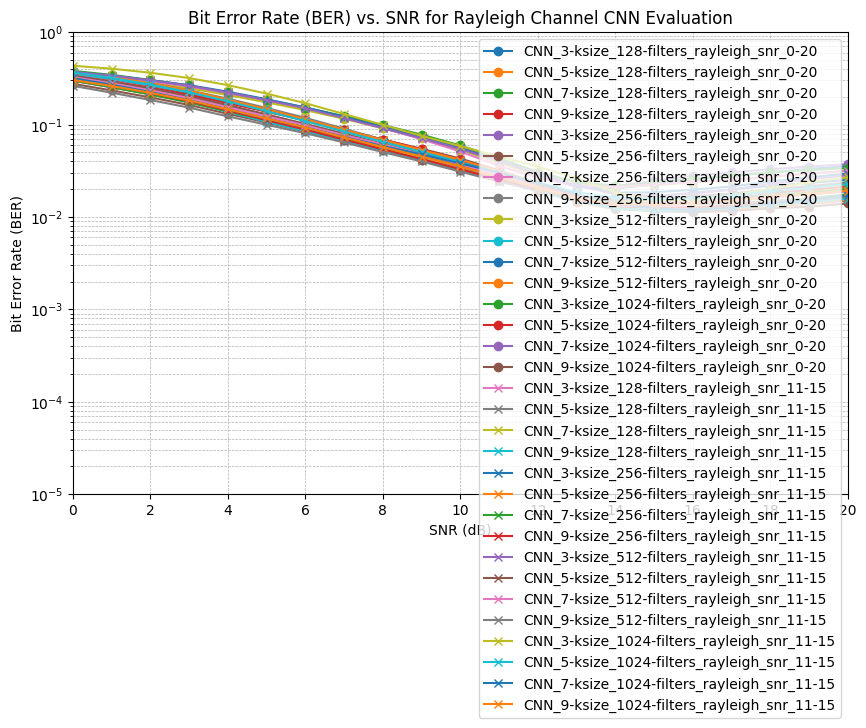

Grafico salvato come /content/drive/MyDrive/GitHub/Rayleigh/results/ber_cnn_all_models.png


In [10]:
# === Impostazioni di base ===
cnn_model_folder = "/content/drive/MyDrive/GitHub/Rayleigh/trained_models/cnn"
snr_test_data_path = "/content/drive/MyDrive/GitHub/Rayleigh/dataset/test"
results_folder = "/content/drive/MyDrive/GitHub/Rayleigh/results"

os.makedirs(results_folder, exist_ok=True)  # Crea la cartella dei risultati se non esiste

ber_results = {}
snr_points = None  # Verrà popolato durante il primo calcolo

for model_file in os.listdir(cnn_model_folder):
    if model_file.endswith(".h5"):
        model_name = model_file.replace(".h5", "")
        model_path = os.path.join(cnn_model_folder, model_file)
        result_file = os.path.join(results_folder, f"{model_name}_ber.npy")

        # Se esistono già i risultati, caricali
        if os.path.exists(result_file):
            print(f"Risultati già presenti per {model_name}, caricamento da file...")
            ber_values = np.load(result_file)
        else:
            print(f"\nCaricamento modello: {model_name}")
            model = load_model(model_path)
            ber_values, snr_points = calculate_ber(model, snr_test_data_path)
            np.save(result_file, ber_values)  # Salva risultati
            print(f"BER salvato in: {result_file}")

        ber_results[model_name] = ber_values
        print(f"BER per {model_name}: {ber_values}")

# === Plot finale ===
plot_ber(
    snr_points,
    ber_results,
    channel_type="Rayleigh",
    title_suffix="CNN Evaluation",
    filename=os.path.join(results_folder, "ber_cnn_all_models.png")
)
